# Cell 1: Import Required Libraries

Import essential libraries for data processing, visualization, and deep learning

In [1]:
!pip install keras-tuner visualkeras tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 36.5 MB/s eta 0:00:00


In [2]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import cv2
import random
import itertools
import pathlib
import shutil
import time
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import visualkeras
import tensorflow as tf
import keras_tuner as kt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import warnings

2025-04-06 22:43:37.997419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-06 22:43:37.997525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-06 22:43:37.999436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-06 22:43:38.009734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-06 22:43:39.243721: W tensorflow/compiler/tf2

In [3]:
model_file = "best_model_16.h5"
arch_file = "model_architecure_16.png"
log_dir_name = "logs_16"
num_folds = 5

In [4]:
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# Cell 2: Data Loading and Preprocessing

Load and organize training and test data paths with their corresponding labels

In [5]:
data_dir = '/notebooks/Datasets/ChestXRayFourClasses'

filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    # Check if the current item is a directory before proceeding
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

# Cell 3: Dataset Splitting

Split the dataset into training, validation, and test sets

In [6]:
# Split the dataset into training and test sets (keeping test set separate)
train_val_df, test_df = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=123, stratify=df['labels'])

print(f"Training/Validation set size: {len(train_val_df)}")
print(f"Test set size: {len(test_df)}")
print(f"Class distribution in train/val set:")
print(train_val_df['labels'].value_counts())
print(f"Class distribution in test set:")
print(test_df['labels'].value_counts())

Training/Validation set size: 9975
Test set size: 2494
Class distribution in train/val set:
labels
Pneumonia       3480
Tuberculosis    2853
Normal          2617
COVID-19        1025
Name: count, dtype: int64
Class distribution in test set:
labels
Pneumonia       871
Tuberculosis    713
Normal          654
COVID-19        256
Name: count, dtype: int64


# Cell 4: Data Generator Setup

Configure image data generators for training, validation, and testing crobed image size

In [7]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1,
                      ts_length + 1) if ts_length % n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.


def scalar(img):
    return img


tr_gen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=10,          # Rotate images by up to 10 degrees
    # width_shift_range=0.2,      # Shift images horizontally by up to 20% of the width
    # height_shift_range=0.2,     # Shift images vertically by up to 20% of the height
    shear_range=0.2,            # Shear images by up to 20 degrees
    zoom_range=0.2,             # Zoom images by up to 20%
    horizontal_flip=True,       # Flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels with the nearest value
)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_val_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(train_val_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 9975 validated image filenames belonging to 4 classes.
Found 9975 validated image filenames belonging to 4 classes.
Found 2493 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


# Cell 5: Data Visualization

Display sample images from the training dataset with their corresponding labels

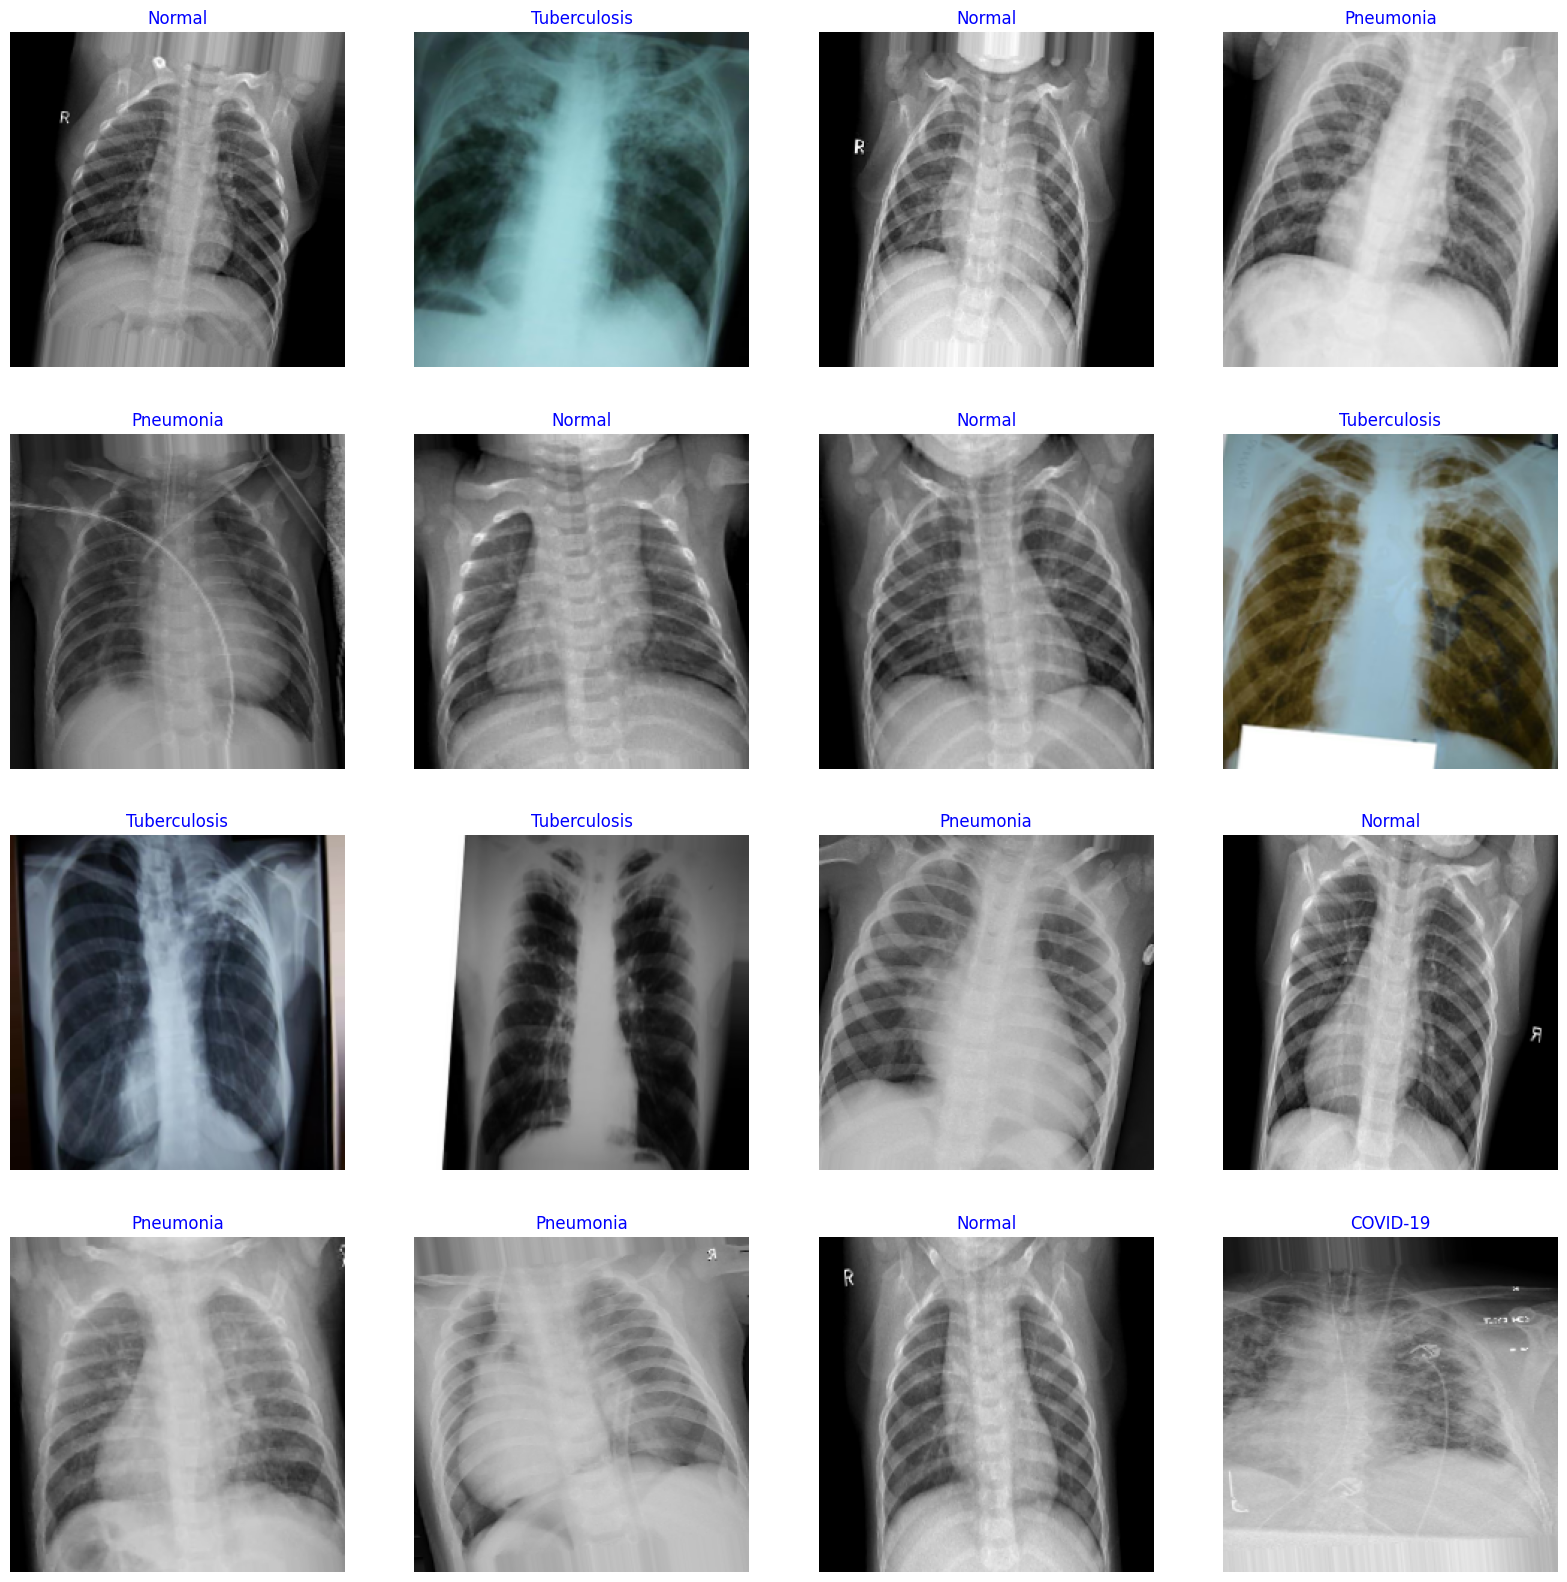

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
# defines list of dictionary's kays (classes), classes names : string
classes = list(g_dict.keys())
# get a batch size samples from the generator
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

# Cell 6: Model Architecture

Define and compile the EfficientNet model with custom layers

In [ ]:
def create_attention_enhanced_model(base_model, num_classes):
    """Create an EfficientNet model enhanced with attention mechanisms"""

    # Get the output from EfficientNet
    x = base_model.output

    # Convert to the right shape for attention
    # First global pooling to reduce spatial dimensions
    x_gap = tf.keras.layers.GlobalAveragePooling2D()(x)
    x_gap = tf.keras.layers.Reshape((1, x_gap.shape[-1]))(x_gap)

    # Apply self-attention to capture global dependencies
    attention_output = MultiHeadAttention(
        num_heads=4, key_dim=64
    )(x_gap, x_gap)

    # Add residual connection and normalization
    x_attention = Add()([x_gap, attention_output])
    x_attention = LayerNormalization(epsilon=1e-6)(x_attention)

    # Flatten and add classification head
    x_attention = tf.keras.layers.Flatten()(x_attention)
    x_attention = tf.keras.layers.Dropout(0.5)(x_attention)
    x_attention = tf.keras.layers.Dense(256, activation='relu')(x_attention)
    outputs = tf.keras.layers.Dense(
        num_classes, activation='softmax')(x_attention)

    return tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

In [ ]:
# Initialize the base model
efficientNet = tf.keras.applications.efficientnet.EfficientNetB0(
    weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

2025-03-30 20:16:18.750207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-30 20:16:18.829171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-30 20:16:18.829462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Create the enhanced model
model = create_attention_enhanced_model(
    efficientNet, len(train_gen.class_indices))

In [ ]:
for layer in model.layers:
    print(f"Layer Name: {layer.name}")
    print(f"Input Shape: {layer.input_shape}")
    print(f"Output Shape: {layer.output_shape}")
    print("-" * 20)

Layer Name: input_1
Input Shape: [(None, 224, 224, 3)]
Output Shape: [(None, 224, 224, 3)]
--------------------
Layer Name: rescaling
Input Shape: (None, 224, 224, 3)
Output Shape: (None, 224, 224, 3)
--------------------
Layer Name: normalization
Input Shape: (None, 224, 224, 3)
Output Shape: (None, 224, 224, 3)
--------------------
Layer Name: rescaling_1
Input Shape: (None, 224, 224, 3)
Output Shape: (None, 224, 224, 3)
--------------------
Layer Name: stem_conv_pad
Input Shape: (None, 224, 224, 3)
Output Shape: (None, 225, 225, 3)
--------------------
Layer Name: stem_conv
Input Shape: (None, 225, 225, 3)
Output Shape: (None, 112, 112, 32)
--------------------
Layer Name: stem_bn
Input Shape: (None, 112, 112, 32)
Output Shape: (None, 112, 112, 32)
--------------------
Layer Name: stem_activation
Input Shape: (None, 112, 112, 32)
Output Shape: (None, 112, 112, 32)
--------------------
Layer Name: block1a_dwconv
Input Shape: (None, 112, 112, 32)
Output Shape: (None, 112, 112, 32)
---

In [ ]:
for layer in model.layers:
    print(f"Layer Name: {layer.name}")
    print(f"Layer Configuration: {layer.get_config()}")
    print("-" * 20)

Layer Name: input_1
Layer Configuration: {'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}
--------------------
Layer Name: rescaling
Layer Configuration: {'name': 'rescaling', 'trainable': True, 'dtype': 'float32', 'scale': 0.00392156862745098, 'offset': 0.0}
--------------------
Layer Name: normalization
Layer Configuration: {'name': 'normalization', 'trainable': True, 'dtype': 'float32', 'axis': (3,), 'invert': False, 'mean': None, 'variance': None}
--------------------
Layer Name: rescaling_1
Layer Configuration: {'name': 'rescaling_1', 'trainable': True, 'dtype': 'float32', 'scale': ListWrapper([2.0896918976428642, 2.1128856368212916, 2.1081851067789197]), 'offset': 0.0}
--------------------
Layer Name: stem_conv_pad
Layer Configuration: {'name': 'stem_conv_pad', 'trainable': True, 'dtype': 'float32', 'padding': ((0, 1), (0, 1)), 'data_format': 'channels_last'}
--------------------
Layer Name: stem_conv
Layer Config

In [ ]:
total_params = model.count_params()
trainable_params = int(np.sum([K.count_params(p)
                       for p in model.trainable_weights]))
non_trainable_params = int(
    np.sum([K.count_params(p) for p in model.non_trainable_weights]))

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")

Total Parameters: 5693863
Trainable Parameters: 5651840
Non-Trainable Parameters: 42023


In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
# optimizer = model.optimizer
print(f"Optimizer: {model.optimizer.__class__.__name__}")
print(f"Learning Rate: {model.optimizer.learning_rate.numpy()}")
# You can also access other optimizer properties like momentum, decay, etc.

Optimizer: Adam
Learning Rate: 0.0010000000474974513


In [ ]:
tensorboard = TensorBoard(log_dir=log_dir_name)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    model_file, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)

# Cell 7: K-fold Cross Validation

Implement K-fold cross-validation to evaluate model performance more robustly

Starting K-fold cross validation...
Classes: ['COVID-19' 'Normal' 'Pneumonia' 'Tuberculosis']

Fold 1/5
Training samples: 7980, Validation samples: 1995
Found 7980 validated image filenames belonging to 4 classes.
Found 1995 validated image filenames belonging to 4 classes.
Epoch 1/50


2025-03-30 20:16:47.717080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-30 20:16:51.458370: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-30 20:16:53.919069: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc0cd48cfe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-30 20:16:53.919156: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2025-03-30 20:16:53.951381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743365814.147500     111 device_compiler.h:186] Compiled cluster using XLA!  This li

250/250 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.8658
Epoch 1: val_loss improved from inf to 0.28561, saving model to best_model_fold_1.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 352s 1s/step - loss: 0.4588 - accuracy: 0.8658 - val_loss: 0.2856 - val_accuracy: 0.9148 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9365
Epoch 2: val_loss improved from 0.28561 to 0.22479, saving model to best_model_fold_1.h5
250/250 [==============================] - 258s 1s/step - loss: 0.2016 - accuracy: 0.9365 - val_loss: 0.2248 - val_accuracy: 0.9188 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.9446
Epoch 3: val_loss did not improve from 0.22479
250/250 [==============================] - 239s 953ms/step - loss: 0.1740 - accuracy: 0.9446 - val_loss: 0.2555 - val_accuracy: 0.9198 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.9553
Epoch 4: val_loss did not improve from 0.22479

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
250/250 [====

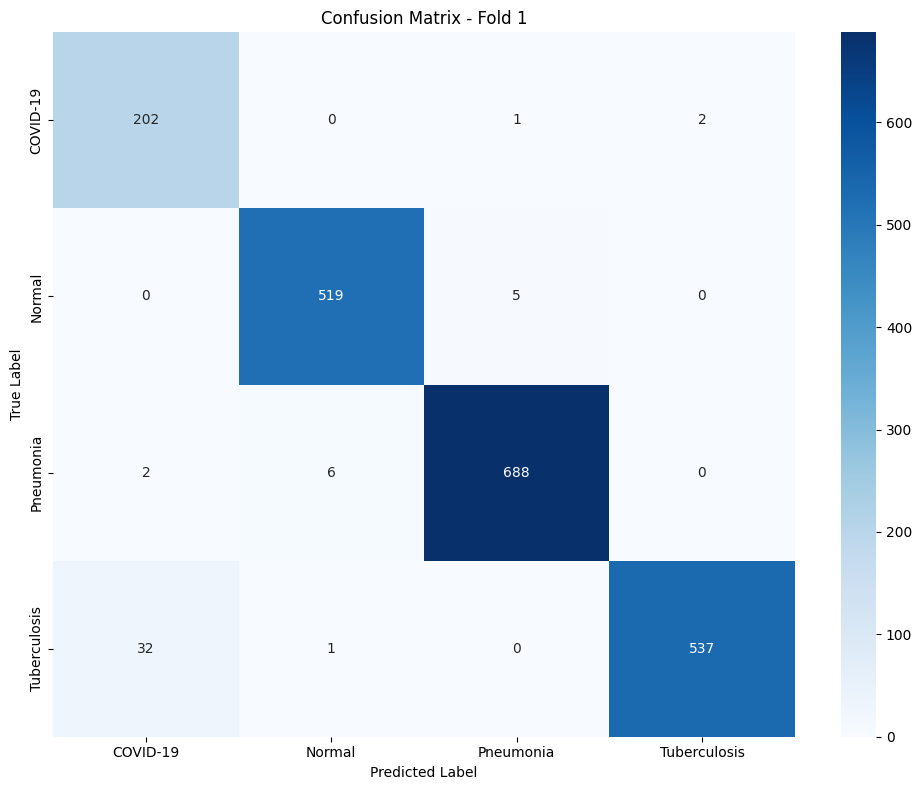

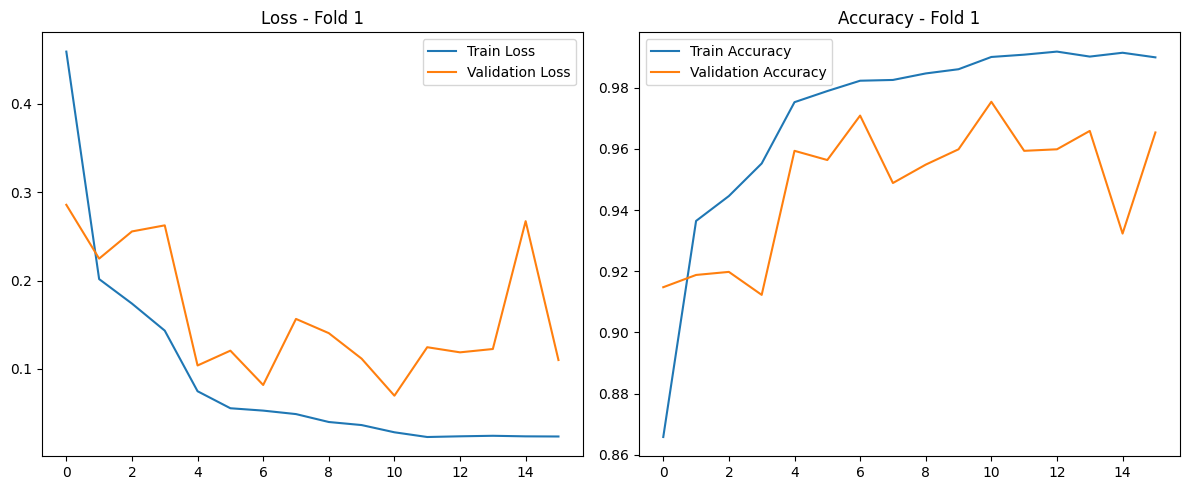


Fold 2/5
Training samples: 7980, Validation samples: 1995
Found 7980 validated image filenames belonging to 4 classes.
Found 1995 validated image filenames belonging to 4 classes.
Epoch 1/50


2025-03-30 21:13:12.027708: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - ETA: 0s - loss: 0.4655 - accuracy: 0.8677
Epoch 1: val_loss improved from inf to 0.21619, saving model to best_model_fold_2.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 227s 743ms/step - loss: 0.4655 - accuracy: 0.8677 - val_loss: 0.2162 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9310
Epoch 2: val_loss improved from 0.21619 to 0.12944, saving model to best_model_fold_2.h5
250/250 [==============================] - 196s 782ms/step - loss: 0.2206 - accuracy: 0.9310 - val_loss: 0.1294 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9396
Epoch 3: val_loss improved from 0.12944 to 0.12186, saving model to best_model_fold_2.h5
250/250 [==============================] - 212s 845ms/step - loss: 0.1958 - accuracy: 0.9396 - val_loss: 0.1219 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9499
Epoch 4: val_loss did not improve from 0.12186
250/250 [==============================] - 

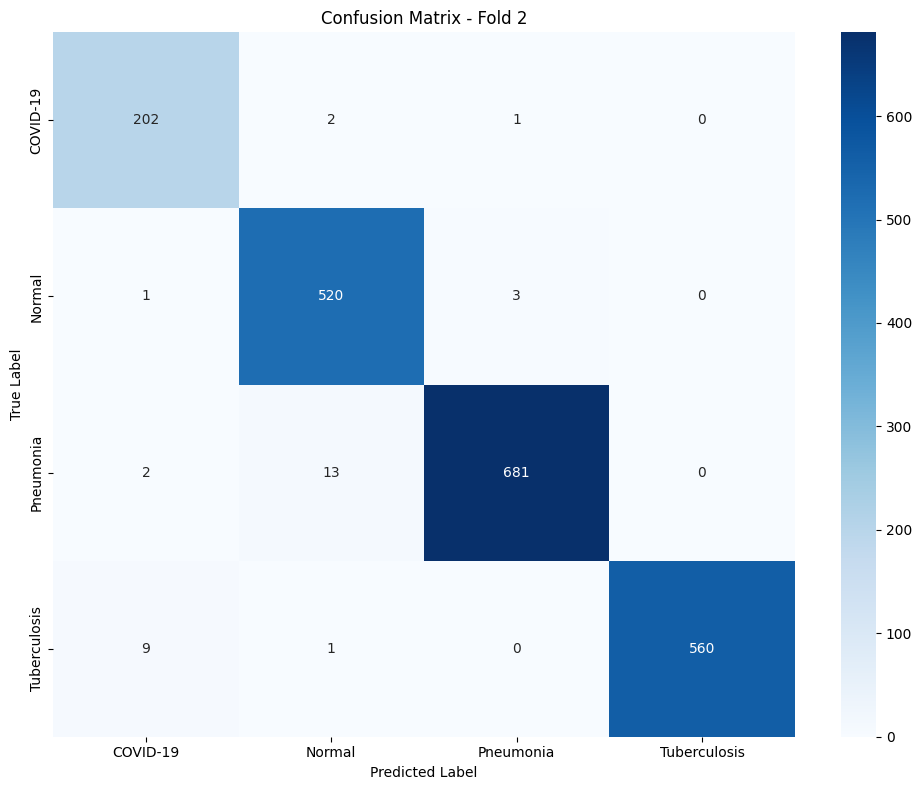

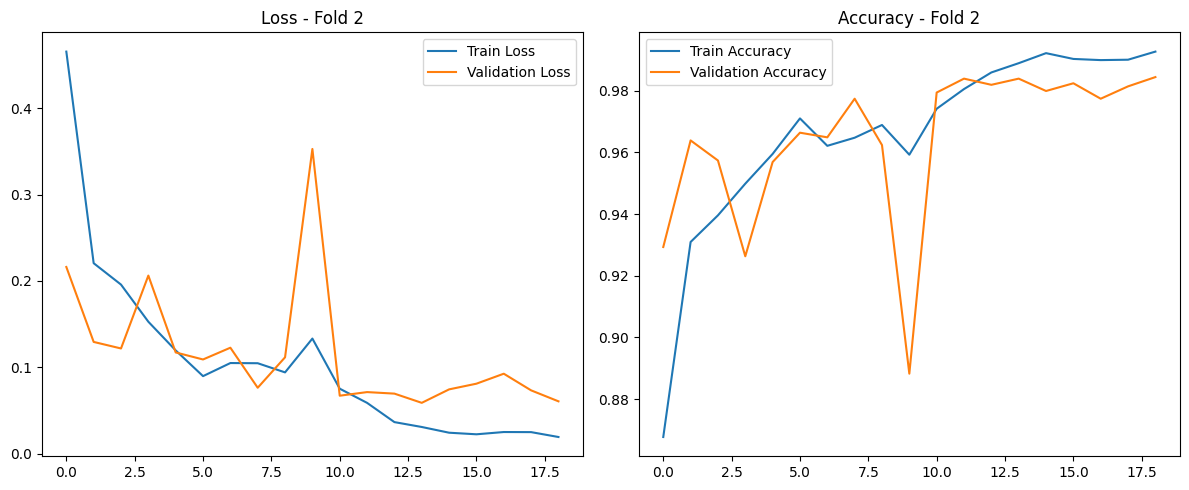


Fold 3/5
Training samples: 7980, Validation samples: 1995
Found 7980 validated image filenames belonging to 4 classes.
Found 1995 validated image filenames belonging to 4 classes.
Epoch 1/50


2025-03-30 22:15:53.848117: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - ETA: 0s - loss: 0.4296 - accuracy: 0.8774
Epoch 1: val_loss improved from inf to 0.30578, saving model to best_model_fold_3.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 229s 738ms/step - loss: 0.4296 - accuracy: 0.8774 - val_loss: 0.3058 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9347
Epoch 2: val_loss improved from 0.30578 to 0.18636, saving model to best_model_fold_3.h5
250/250 [==============================] - 191s 764ms/step - loss: 0.1991 - accuracy: 0.9347 - val_loss: 0.1864 - val_accuracy: 0.9404 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9464
Epoch 3: val_loss did not improve from 0.18636
250/250 [==============================] - 186s 744ms/step - loss: 0.1623 - accuracy: 0.9464 - val_loss: 0.3793 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9559
Epoch 4: val_loss did not improve from 0.18636

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
250/250

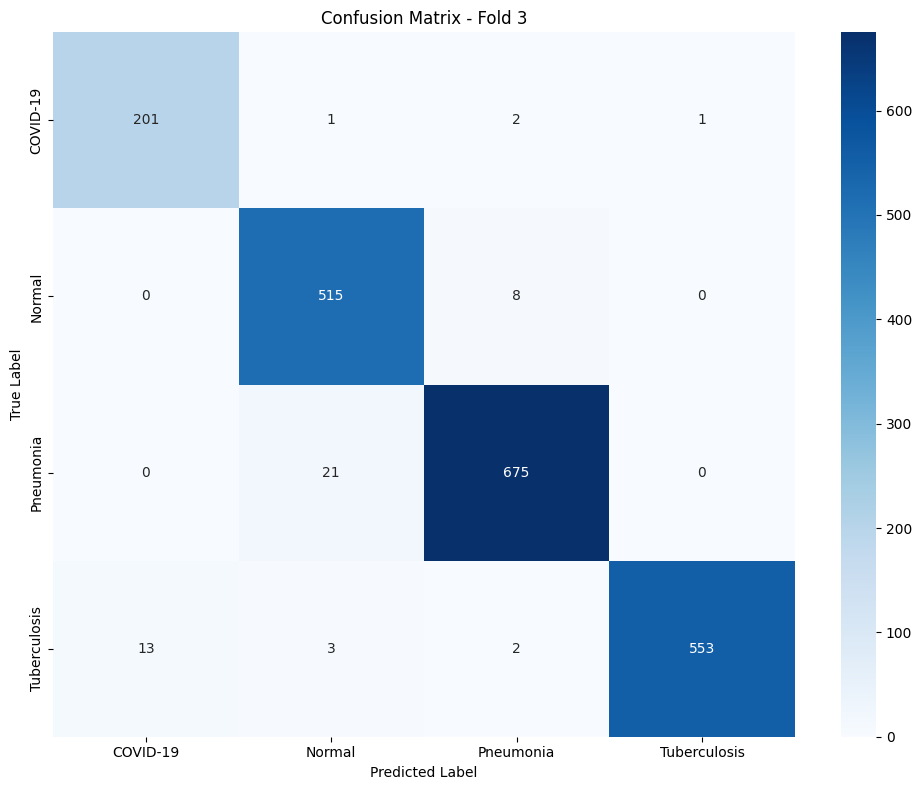

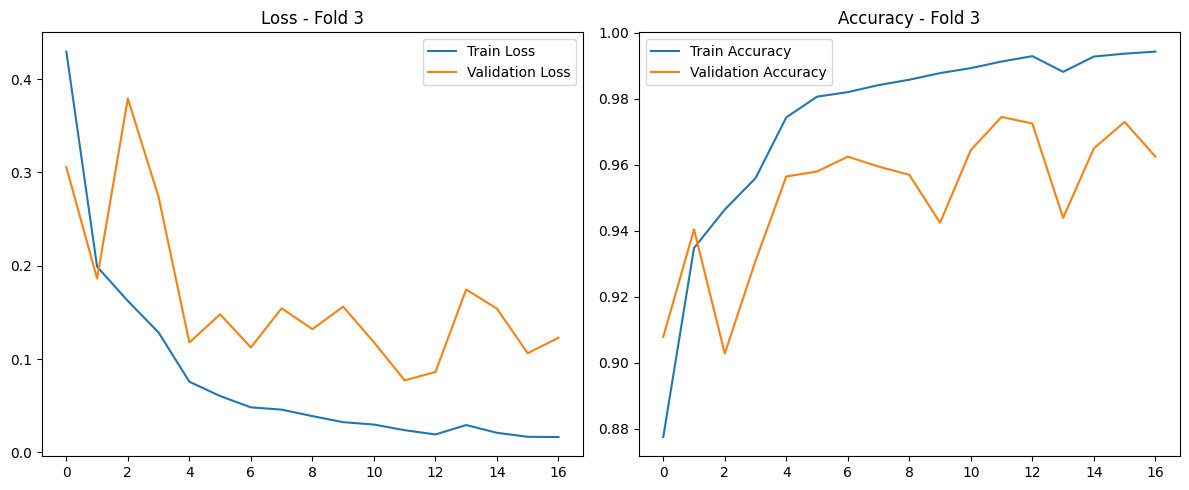


Fold 4/5
Training samples: 7980, Validation samples: 1995
Found 7980 validated image filenames belonging to 4 classes.
Found 1995 validated image filenames belonging to 4 classes.
Epoch 1/50


2025-03-30 23:11:43.162544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8802
Epoch 1: val_loss improved from inf to 0.17238, saving model to best_model_fold_4.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 217s 709ms/step - loss: 0.4266 - accuracy: 0.8802 - val_loss: 0.1724 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9227
Epoch 2: val_loss improved from 0.17238 to 0.14246, saving model to best_model_fold_4.h5
250/250 [==============================] - 183s 730ms/step - loss: 0.2461 - accuracy: 0.9227 - val_loss: 0.1425 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9469
Epoch 3: val_loss did not improve from 0.14246
250/250 [==============================] - 182s 726ms/step - loss: 0.1507 - accuracy: 0.9469 - val_loss: 0.4086 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9509
Epoch 4: val_loss did not improve from 0.14246

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
250/250

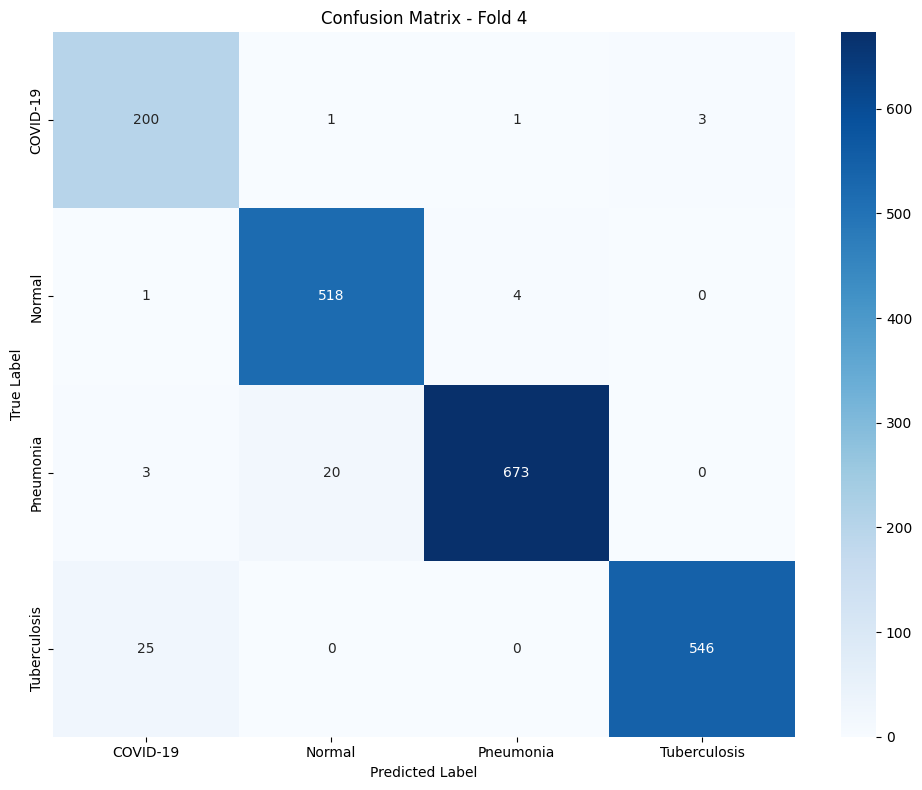

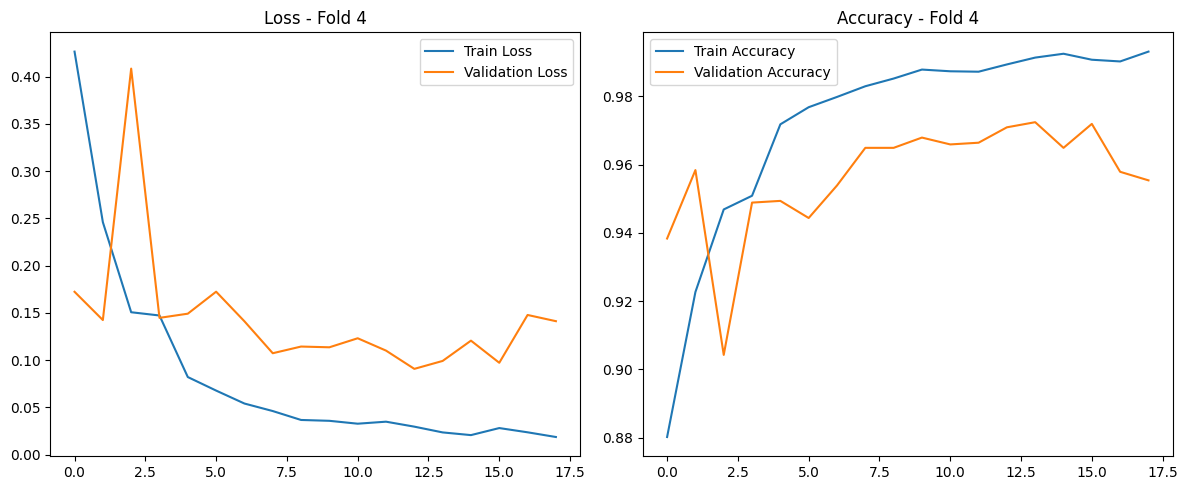


Fold 5/5
Training samples: 7980, Validation samples: 1995
Found 7980 validated image filenames belonging to 4 classes.
Found 1995 validated image filenames belonging to 4 classes.
Epoch 1/50


2025-03-31 00:11:42.258903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


250/250 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.8788
Epoch 1: val_loss improved from inf to 0.41083, saving model to best_model_fold_5.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 215s 693ms/step - loss: 0.4312 - accuracy: 0.8788 - val_loss: 0.4108 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9227
Epoch 2: val_loss improved from 0.41083 to 0.17172, saving model to best_model_fold_5.h5
250/250 [==============================] - 179s 714ms/step - loss: 0.2400 - accuracy: 0.9227 - val_loss: 0.1717 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.9442
Epoch 3: val_loss did not improve from 0.17172
250/250 [==============================] - 180s 718ms/step - loss: 0.1834 - accuracy: 0.9442 - val_loss: 0.1910 - val_accuracy: 0.9338 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9569
Epoch 4: val_loss did not improve from 0.17172

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
250/250

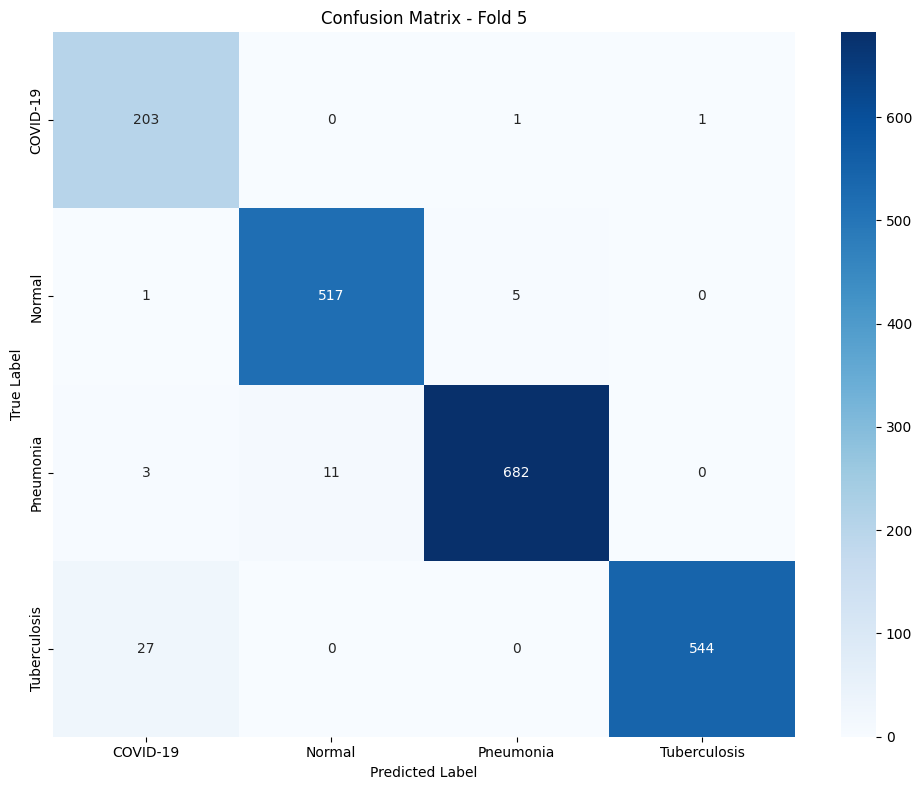

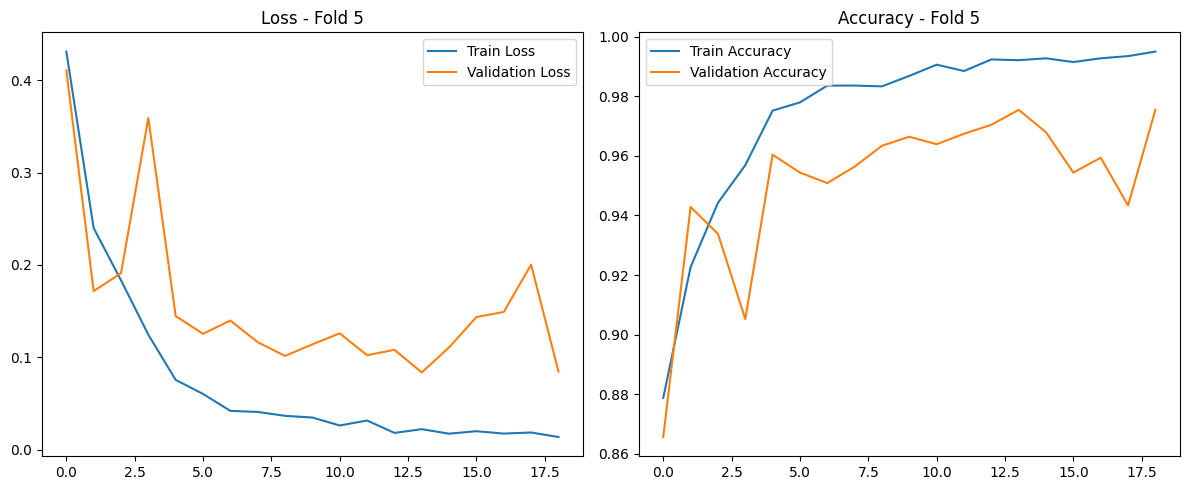

In [ ]:
# Use StratifiedKFold to maintain class distribution across folds
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Convert labels to numeric format for stratification
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(train_val_df['labels'])

# Arrays to store results
fold_no = 1
fold_accuracy = []
fold_loss = []
fold_val_accuracy = []
fold_val_loss = []
fold_precision = []
fold_recall = []
fold_f1 = []

# Create directories for logs and model files
os.makedirs(log_dir_name, exist_ok=True)

print("Starting K-fold cross validation...")
print(f"Classes: {np.unique(train_val_df['labels'])}")

for train_idx, val_idx in kfold.split(train_val_df, y_numeric):
    print(f"\nFold {fold_no}/{num_folds}")

    # Create train and validation dataframes for this fold
    fold_train_df = train_val_df.iloc[train_idx].reset_index(drop=True)
    fold_val_df = train_val_df.iloc[val_idx].reset_index(drop=True)

    print(
        f"Training samples: {len(fold_train_df)}, Validation samples: {len(fold_val_df)}")

    # Create data generators for this fold
    fold_train_gen = tr_gen.flow_from_dataframe(
        fold_train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    fold_val_gen = ts_gen.flow_from_dataframe(
        fold_val_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=batch_size
    )

    # Clear previous model and create a new one
    tf.keras.backend.clear_session()

    # Initialize the base model
    efficientNet = tf.keras.applications.efficientnet.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )

    # Create model
    model = create_attention_enhanced_model(
        efficientNet, len(fold_train_gen.class_indices))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='Adam',
        metrics=['accuracy']
    )

    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(fold_train_df['labels']),
        y=fold_train_df['labels']
    )

    class_weights_dict = {fold_train_gen.class_indices[cls]: weight for cls, weight
                          in zip(np.unique(fold_train_df['labels']), class_weights)}

    # Set up callbacks for this fold
    fold_model_file = f"best_model_fold_{fold_no}.h5"
    fold_log_dir = os.path.join(log_dir_name, f"fold_{fold_no}")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5,
                      verbose=1, restore_best_weights=True),
        ModelCheckpoint(fold_model_file, monitor='val_loss',
                        save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=2, min_lr=0.0001, verbose=1),
        TensorBoard(log_dir=fold_log_dir)
    ]

    # Train the model for this fold
    history = model.fit(
        fold_train_gen,
        steps_per_epoch=len(fold_train_gen),
        epochs=50,
        validation_data=fold_val_gen,
        validation_steps=len(fold_val_gen),
        callbacks=callbacks,
        class_weight=class_weights_dict,
        verbose=1
    )

    # Evaluate the model on validation data
    val_results = model.evaluate(
        fold_val_gen, steps=len(fold_val_gen), verbose=1)
    print(f"Validation Loss for fold {fold_no}: {val_results[0]}")
    print(f"Validation Accuracy for fold {fold_no}: {val_results[1]}")

    # Store fold results
    fold_accuracy.append(history.history['accuracy'][-1])
    fold_loss.append(history.history['loss'][-1])
    fold_val_accuracy.append(val_results[1])
    fold_val_loss.append(val_results[0])

    # Generate predictions for validation set
    y_pred = np.argmax(model.predict(fold_val_gen), axis=1)
    y_true = fold_val_gen.classes

    # Calculate classification metrics
    report = classification_report(y_true, y_pred,
                                   target_names=list(
                                       fold_train_gen.class_indices.keys()),
                                   output_dict=True)

    fold_precision.append(report['weighted avg']['precision'])
    fold_recall.append(report['weighted avg']['recall'])
    fold_f1.append(report['weighted avg']['f1-score'])

    # Plot confusion matrix for this fold
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(fold_train_gen.class_indices.keys()),
                yticklabels=list(fold_train_gen.class_indices.keys()))
    plt.title(f'Confusion Matrix - Fold {fold_no}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_fold_{fold_no}.png')
    plt.show()

    # Plot training history for this fold
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - Fold {fold_no}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - Fold {fold_no}')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'training_history_fold_{fold_no}.png')
    plt.show()

    # Increment fold number
    fold_no += 1

# Cell 8: K-fold Cross Validation Results

Summarize the performance across all f


========== K-FOLD CROSS VALIDATION RESULTS ==========
Average Training Accuracy: 0.9930 ± 0.0017
Average Training Loss: 0.0184 ± 0.0033
Average Validation Accuracy: 0.9760 ± 0.0043
Average Validation Loss: 0.0761 ± 0.0110
Average Precision: 0.9774 ± 0.0039
Average Recall: 0.9760 ± 0.0043
Average F1 Score: 0.9763 ± 0.0042


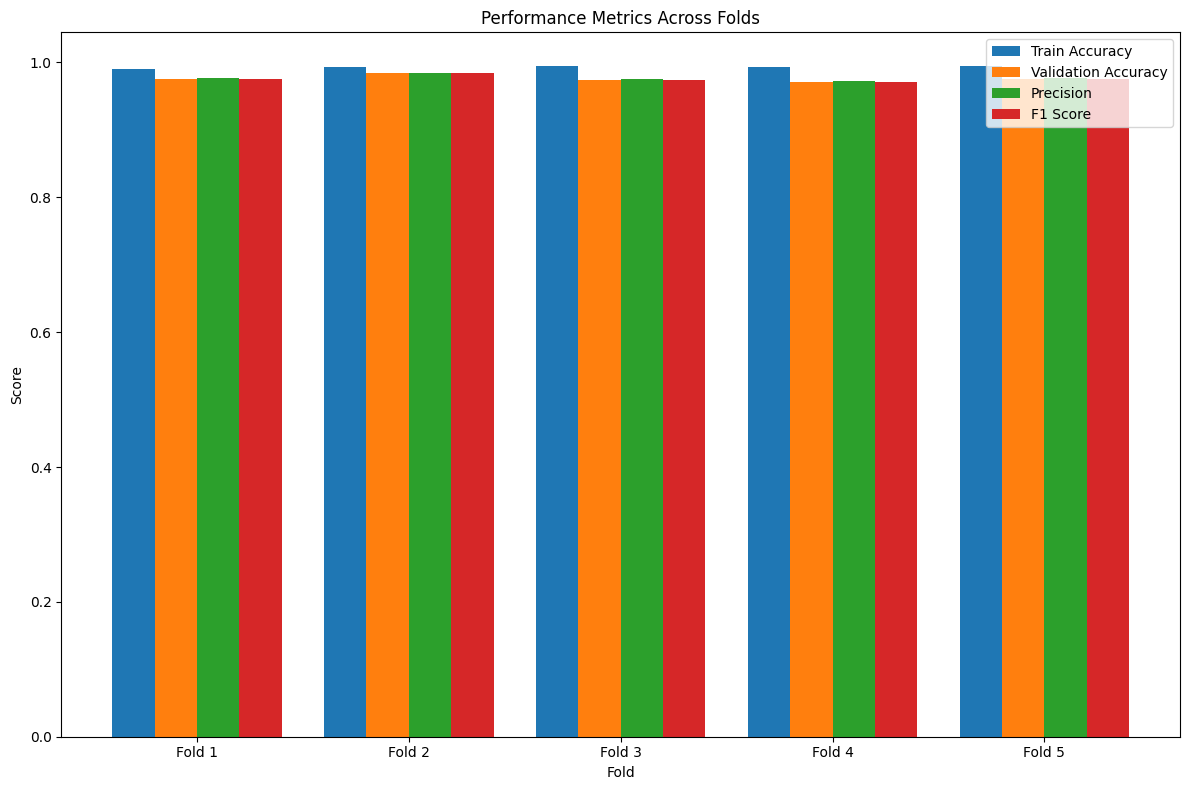

In [ ]:
print("\n========== K-FOLD CROSS VALIDATION RESULTS ==========")
print(
    f"Average Training Accuracy: {np.mean(fold_accuracy):.4f} ± {np.std(fold_accuracy):.4f}")
print(
    f"Average Training Loss: {np.mean(fold_loss):.4f} ± {np.std(fold_loss):.4f}")
print(
    f"Average Validation Accuracy: {np.mean(fold_val_accuracy):.4f} ± {np.std(fold_val_accuracy):.4f}")
print(
    f"Average Validation Loss: {np.mean(fold_val_loss):.4f} ± {np.std(fold_val_loss):.4f}")
print(
    f"Average Precision: {np.mean(fold_precision):.4f} ± {np.std(fold_precision):.4f}")
print(
    f"Average Recall: {np.mean(fold_recall):.4f} ± {np.std(fold_recall):.4f}")
print(f"Average F1 Score: {np.mean(fold_f1):.4f} ± {np.std(fold_f1):.4f}")

# Create bar plot for fold comparison
plt.figure(figsize=(12, 8))
x = np.arange(num_folds)
width = 0.2

plt.bar(x - width*1.5, fold_accuracy, width, label='Train Accuracy')
plt.bar(x - width*0.5, fold_val_accuracy, width, label='Validation Accuracy')
plt.bar(x + width*0.5, fold_precision, width, label='Precision')
plt.bar(x + width*1.5, fold_f1, width, label='F1 Score')

plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Performance Metrics Across Folds')
plt.xticks(x, [f'Fold {i+1}' for i in range(num_folds)])
plt.legend()
plt.tight_layout()
plt.savefig('fold_comparison.png')
plt.show()

# Cell 9: Final Model Selection and Evaluation

Select the best model from K-fold CV and evaluate on the test set


Best performing fold: 2 with validation accuracy: 0.9840
43/43 [==============================] - 52s 1s/step - loss: 0.0488 - accuracy: 0.9832
Test Loss: 0.0488
Test Accuracy: 0.9832
43/43 [==============================] - 30s 669ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

    COVID-19       0.96      1.00      0.98       256
      Normal       0.96      1.00      0.98       654
   Pneumonia       1.00      0.98      0.99       871
Tuberculosis       1.00      0.97      0.99       712

    accuracy                           0.98      2493
   macro avg       0.98      0.99      0.98      2493
weighted avg       0.98      0.98      0.98      2493



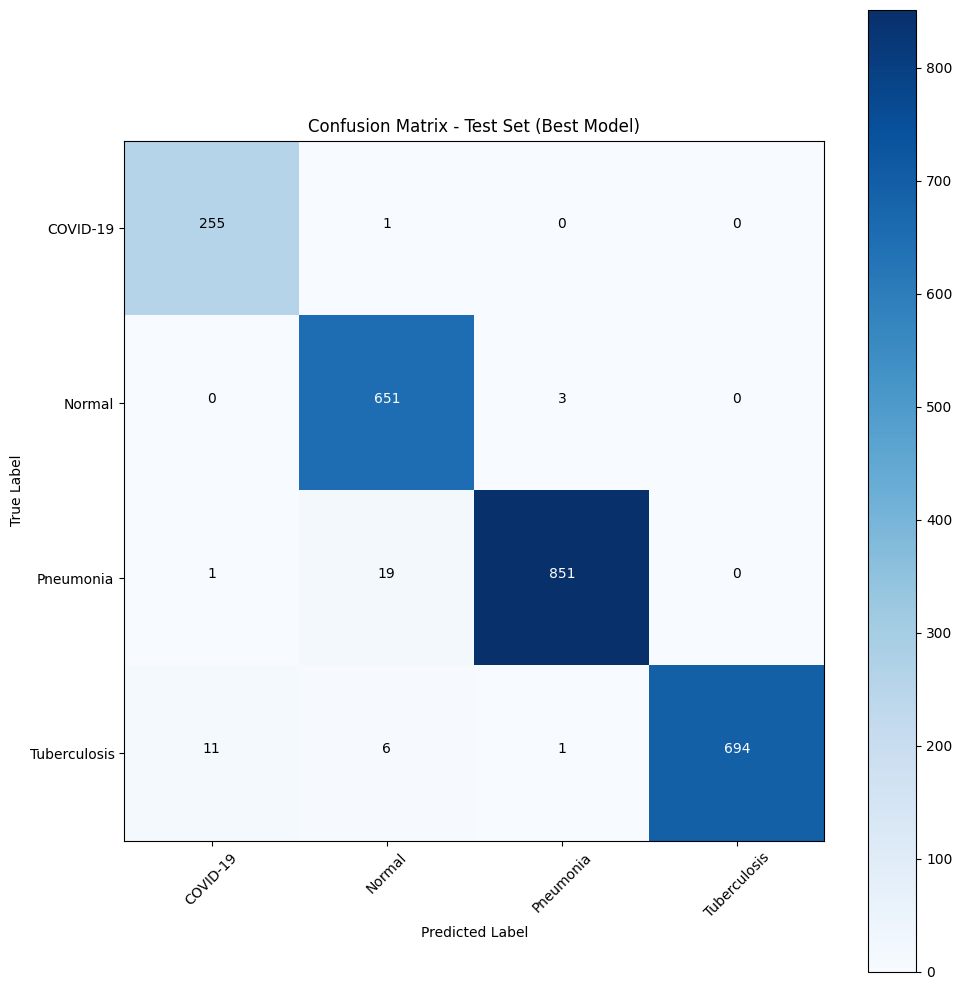

In [ ]:
# Find the best fold based on validation accuracy
best_fold = np.argmax(fold_val_accuracy) + 1
print(
    f"\nBest performing fold: {best_fold} with validation accuracy: {np.max(fold_val_accuracy):.4f}")

# Load the best model
best_model_path = f"best_model_fold_{best_fold}.h5"
best_model = tf.keras.models.load_model(best_model_path)

# Evaluate on test set
test_results = best_model.evaluate(test_gen, steps=test_steps, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

# Generate predictions on test set
test_preds = best_model.predict(test_gen)
test_y_pred = np.argmax(test_preds, axis=1)
test_y_true = test_gen.classes

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(test_y_true, test_y_pred,
      target_names=list(test_gen.class_indices.keys())))

# Plot confusion matrix for test set
plt.figure(figsize=(10, 10))
test_cm = confusion_matrix(test_y_true, test_y_pred)
plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set (Best Model)')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = test_cm.max() / 2.
for i, j in itertools.product(range(test_cm.shape[0]), range(test_cm.shape[1])):
    plt.text(j, i, test_cm[i, j], horizontalalignment='center',
             color='white' if test_cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_test_set.png')
plt.show()

# Show Misclassified Predictions

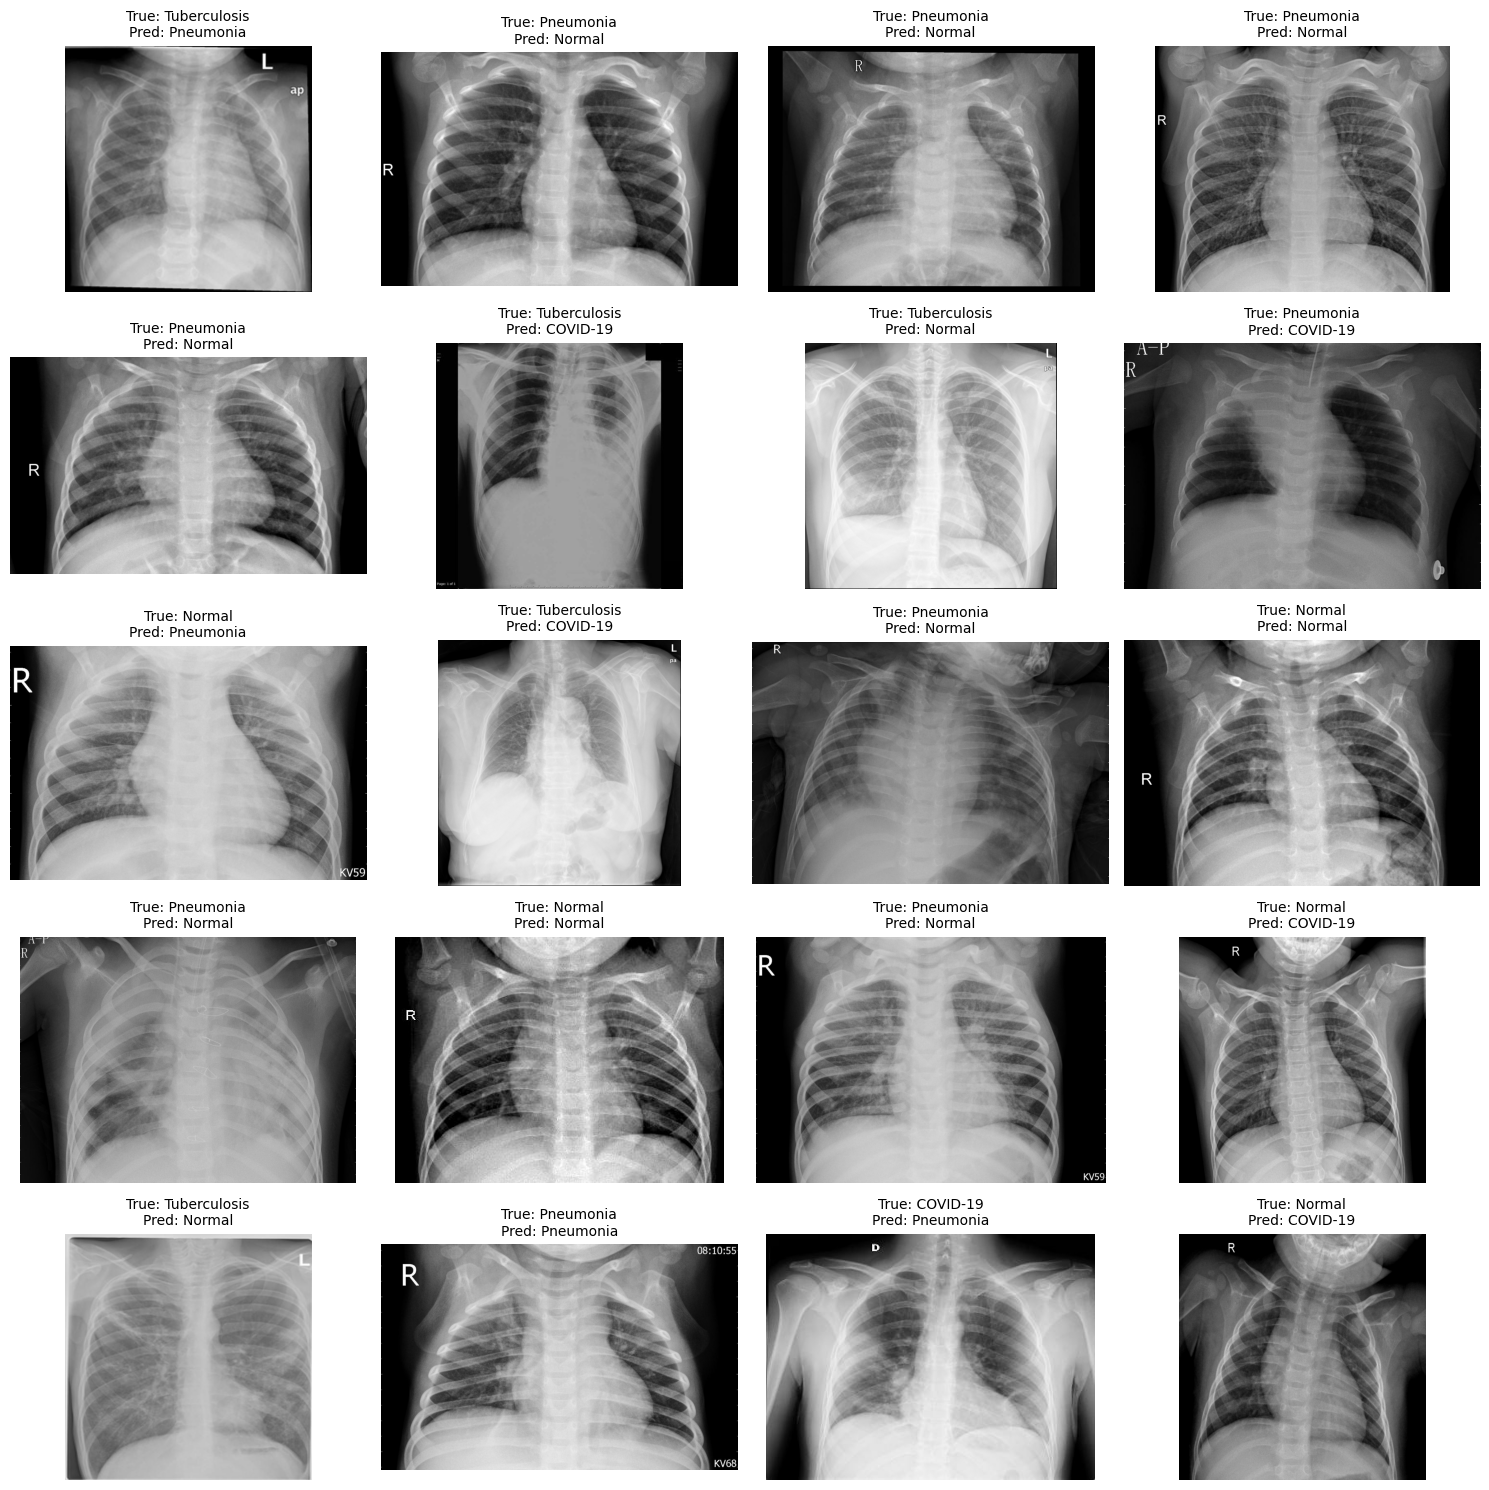

In [ ]:
misclassified_indices = np.where(test_y_pred != test_y_true)[0]
if len(misclassified_indices) > 0:
    misclassified_samples = test_df.iloc[misclassified_indices]

    plt.figure(figsize=(15, 15))
    num_samples = min(len(misclassified_indices), 20)
    for i, idx in enumerate(misclassified_indices[:num_samples]):
        plt.subplot(5, 4, i + 1)
        img_path = misclassified_samples.iloc[i]['filepaths']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        true_label = misclassified_samples.iloc[i]['labels']
        predicted_label = classes[test_y_pred[idx]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('misclassified_samples.png')
    plt.show()
else:
    print("No misclassified samples in the test set (100% accuracy)!")

# Load model

In [9]:
fold2_model = tf.keras.models.load_model('best_model_fold_2.h5')

2025-04-06 22:44:11.554176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-06 22:44:11.624264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-06 22:44:11.624586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Grad-CAM Visualization

2025-04-06 22:44:33.431019: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
/tmp/ipykernel_42/1238783828.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


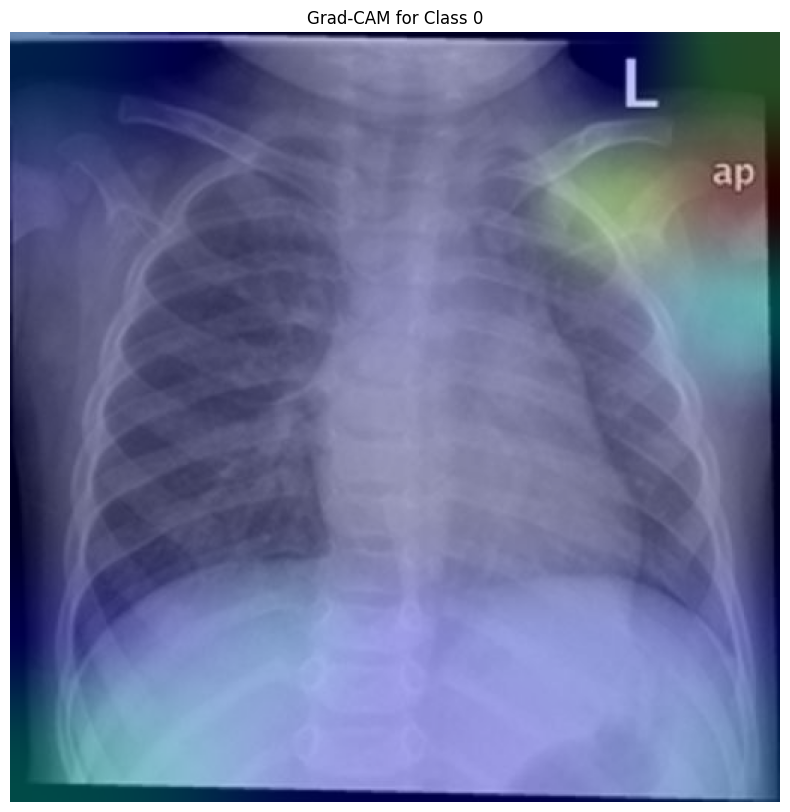

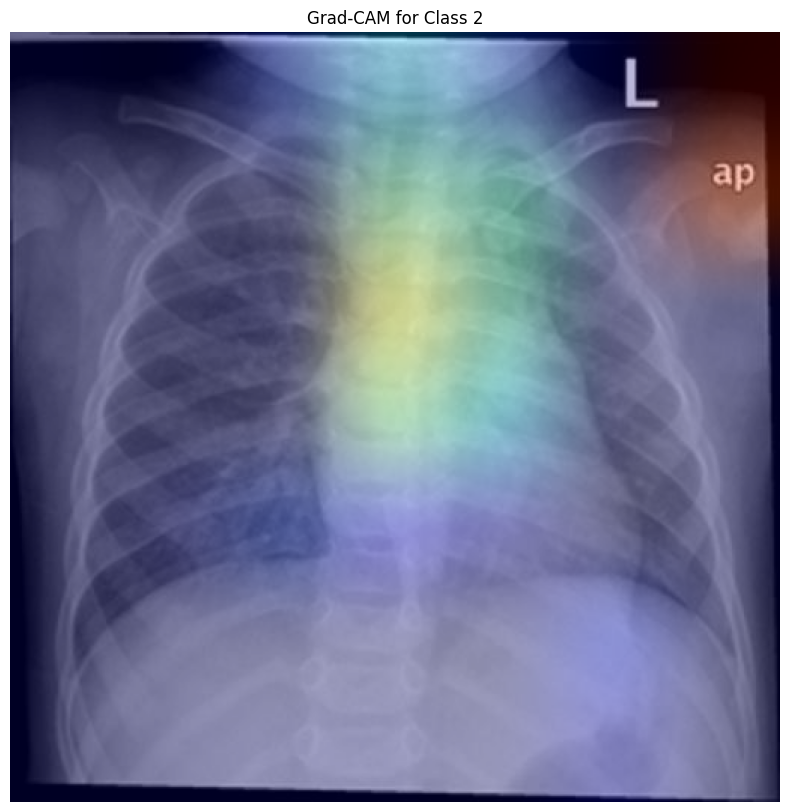

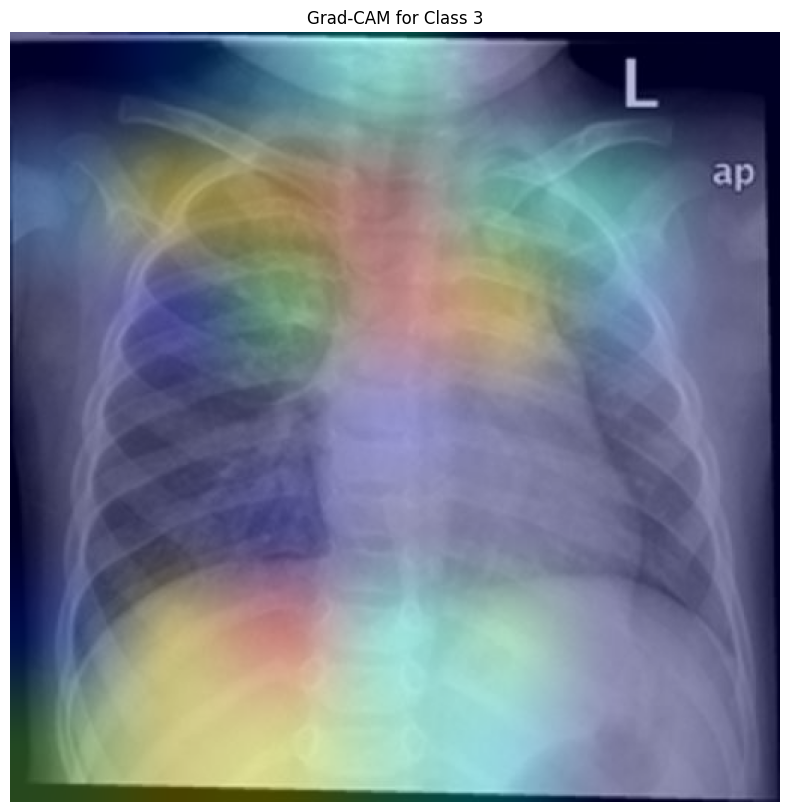

In [10]:
# prompt: get grad cam visualization for this fold2_model for all 4 classes

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Assuming 'fold2_model' is loaded and 'test_df' contains image paths
last_conv_layer_name = "top_conv" # Replace with the actual name of your last convolutional layer

for class_index in range(4): # Assuming 4 classes
    img_path = test_df.iloc[0]['filepaths'] # Replace with the desired image
    img_array = get_img_array(img_path, size=img_size)
    heatmap = make_gradcam_heatmap(img_array, fold2_model, last_conv_layer_name, pred_index=class_index)

    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM for Class {class_index}")
    plt.axis('off')
    plt.show()


/tmp/ipykernel_79/3407564267.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


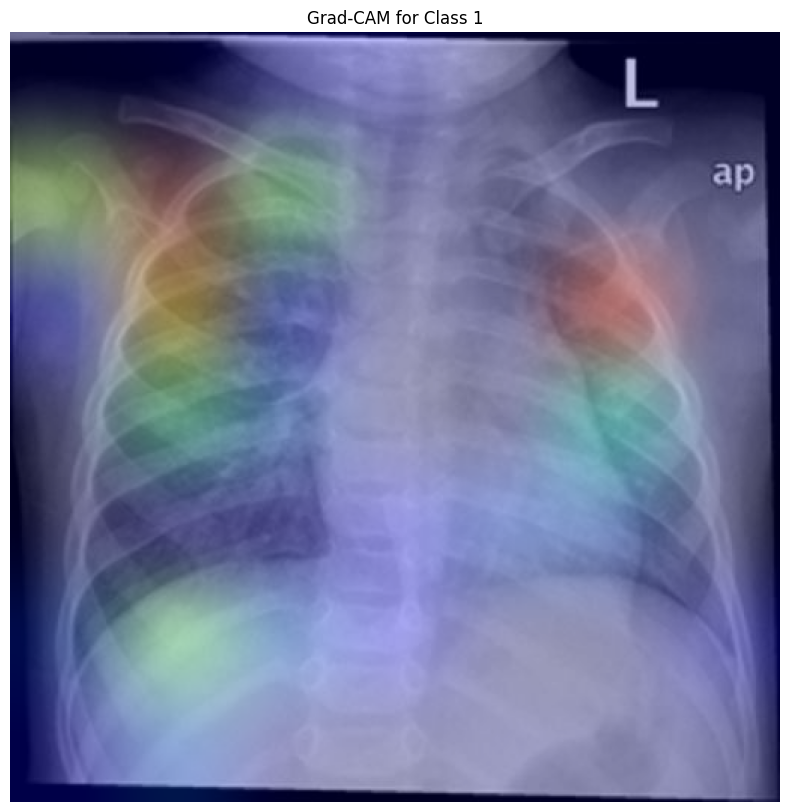

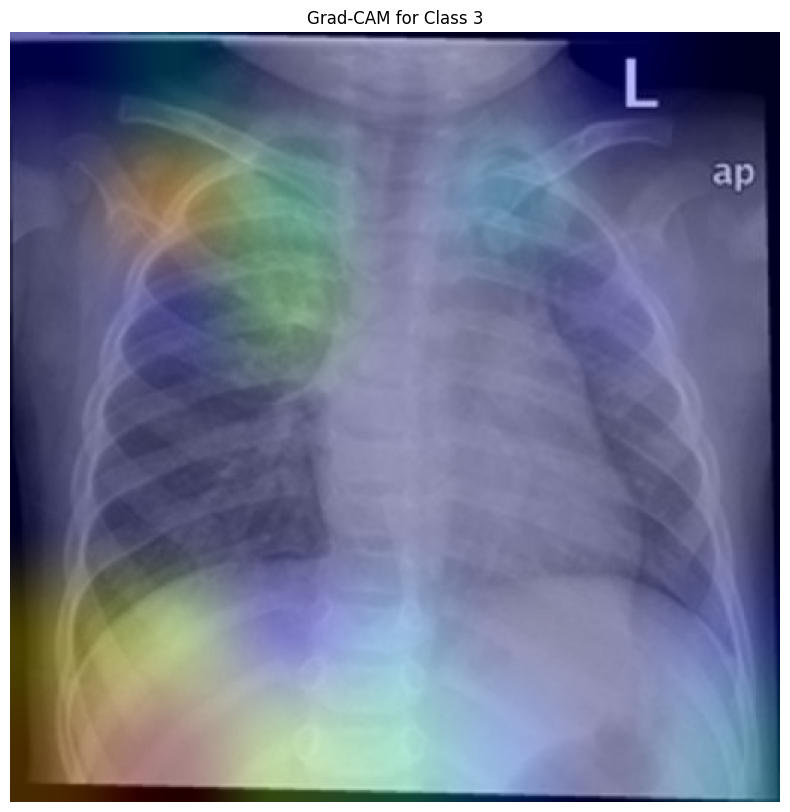

In [34]:
# prompt: get grad cam visualization for this fold2_model for all 4 classes

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Assuming 'fold2_model' is loaded and 'test_df' contains image paths
last_conv_layer_name = "top_activation" # Replace with the actual name of your last convolutional layer

for class_index in range(4): # Assuming 4 classes
    img_path = test_df.iloc[0]['filepaths'] # Replace with the desired image
    img_array = get_img_array(img_path, size=img_size)
    heatmap = make_gradcam_heatmap(img_array, fold2_model, last_conv_layer_name, pred_index=class_index)

    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM for Class {class_index}")
    plt.axis('off')
    plt.show()


# Ignore below

In [30]:
def grad_cam_visualization(model, image, class_index):
    """Generates Grad-CAM visualization for a specific class."""
    
    # Temporarily disable the execution of LayerNormalization
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.LayerNormalization):
            layer.trainable = False  # Make LayerNormalization non-trainable
            layer._call_original = layer.call  # Store the original call method
            def call_replacement(x, training=None):
                return x  # Replace call to simply pass through the input
            layer.call = call_replacement


    gradcam = Gradcam(model, model_modifier=lambda m: m.layers[-5],  # Target layer for GradCAM
                      clone=False)
                      
    # Update the score function to handle model outputs correctly                      
    def score_function(output):
        return output[:, class_index]  

    cam = gradcam(score_function,  # Target class
                  image,
                  penultimate_layer=-1)  # Output layer for GradCAM

    cam = normalize(cam)
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    # Superimpose the heatmap on the original image
    output_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
    
    # Restore the original LayerNormalization behavior
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.LayerNormalization):
            layer.trainable = True
            layer.call = layer._call_original
            del layer._call_original
            
    return output_image

In [31]:
# Example: Get the first image from the test generator
image_batch, labels_batch = test_gen.next()
image = image_batch[0]  # Select the first image

In [32]:
for class_index in range(len(classes)):
    class_name = classes[class_index]
    output_image = grad_cam_visualization(fold2_model, image, class_index)

    plt.imshow(output_image)
    plt.title(f"Grad-CAM for {class_name}")
    plt.axis('off')
    plt.show()

AttributeError: 'LayerNormalization' object has no attribute 'outputs'

> Add everything to /backups/correctpath